In [1]:
# permite a utilização de caminhos relativos ao projeto, mesmo no diretório de notebooks

import numpy as np
import random
from knapsax.optimization import Knapsack
import matplotlib.pyplot as plt
from knapsax.pso import PSO
import time
from tqdm import tqdm
import tracemalloc

import pandas as pd
import seaborn as sns

from knapsax.utils import setrootdir

setrootdir("knapsax")

'Directory knapsax successfully loaded as current working directory.'

In [2]:
knapsack = Knapsack(instance_file="data/knapsack-instance.txt")
knapsack

Knapsack(file=data/knapsack-instance.txt, n_items=100, capacity=1550)

In [3]:
capacity = knapsack.capacity

values = [item.value for item in knapsack.items]
weights = [item.weight for item in knapsack.items]

# Resultados

In [4]:
pso = PSO(n_interations=100, knapsack=knapsack, num_particles=200)

items, best_value, best_weight = pso.run()

In [5]:
print(f"Items: [{', '.join([f'Item(value={i.value}, weight={i.weight})' for i in items])}]")
print("Best Value:", best_value)
print("Weight:", best_weight)


Items: [Item(value=20, weight=16), Item(value=81, weight=58), Item(value=76, weight=72), Item(value=30, weight=15), Item(value=33, weight=23), Item(value=18, weight=12), Item(value=62, weight=50), Item(value=51, weight=37), Item(value=68, weight=54), Item(value=39, weight=25), Item(value=29, weight=21), Item(value=64, weight=48), Item(value=47, weight=33), Item(value=78, weight=64), Item(value=40, weight=27), Item(value=54, weight=39), Item(value=63, weight=47), Item(value=45, weight=29), Item(value=52, weight=36), Item(value=80, weight=67), Item(value=37, weight=24), Item(value=61, weight=49), Item(value=83, weight=71), Item(value=48, weight=32), Item(value=28, weight=20), Item(value=49, weight=34), Item(value=74, weight=61), Item(value=59, weight=44), Item(value=19, weight=13), Item(value=46, weight=30), Item(value=56, weight=41), Item(value=17, weight=11), Item(value=16, weight=10), Item(value=68, weight=54), Item(value=27, weight=19), Item(value=43, weight=31), Item(value=72, weigh

# Análise do comportamento médio

In [6]:
class Stats:
    def __init__(self, n_runs: int, algorithm_instance: object):
        self.n_runs = n_runs
        self.algorithm_instance = algorithm_instance
        self.data = {
            "iteration": [],
            "best_solution": [],
            "best_value": [],
            "best_weight": [],
            "history_value": [],
            "history_weight": [],
            "execution_time": [],
            "memory_peak": [],
            "memory_peak_mb": [],
        }

    def run(self):

        for i in tqdm(range(self.n_runs), desc="Running ACO", unit="run"):
            start_time = time.time()
            tracemalloc.start()
            best_solution, best_value, best_weight = self.algorithm_instance.run()
            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            end_time = time.time()

            self.data["iteration"].append(i)
            self.data["best_solution"].append(best_solution)
            self.data["best_value"].append(best_value)
            self.data["best_weight"].append(best_weight)
            self.data["history_value"].append(self.algorithm_instance.history_value)
            self.data["history_weight"].append(self.algorithm_instance.history_weight)
            self.data["execution_time"].append(end_time - start_time)
            self.data["memory_peak"].append(peak)
            self.data["memory_peak_mb"].append(peak / 10**6)

    def frame(self):
        return pd.DataFrame(self.data)
    
    def plot_convergence(self, title: str, savefig: str = None):
        df = self.frame()

        value_by_run = np.array(df["history_value"].tolist())
        value_by_iteration = value_by_run.T

        means_by_iteration = np.mean(value_by_iteration, axis=1)
        std_by_iteration = np.std(value_by_iteration, axis=1)
        max_value = np.nanmax(value_by_iteration)

        fig, ax = plt.subplots(figsize=(10, 6))

        sns.lineplot(
            x=np.arange(len(means_by_iteration)),
            y=means_by_iteration,
            ax=ax,
            label="Média do custo",
            color="royalblue",
            linewidth=2.5
        )

        ax.fill_between(
            np.arange(len(means_by_iteration)),
            means_by_iteration - std_by_iteration,
            means_by_iteration + std_by_iteration,
            color="royalblue",
            alpha=0.2,
            label="Desvio padrão do custo"
        )

        ax.axhline(
            y=max_value,
            linestyle="--",
            color="forestgreen",
            linewidth=2,
            label=f"Valor máximo = {max_value}"
        )

        ax.set_title(title, fontsize=20)
        ax.set_xlabel("Iteração", fontsize=16)
        ax.set_ylabel("Custo", fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
        ax.legend(fontsize=12, frameon=True)
        plt.tight_layout()

        if savefig:
            plt.savefig(savefig, dpi=600)
        
        return fig, ax

In [7]:
pso_stats = Stats(n_runs=20, algorithm_instance=pso)
pso_stats.run()

Running ACO: 100%|██████████| 20/20 [01:06<00:00,  3.32s/run]


In [8]:
pso_stats.frame()

,iteration,best_solution,best_value,best_weight,history_value,history_weight,execution_time,memory_peak,memory_peak_mb
0,0,"[Item(value=20, weight=16), Item(value=81, wei...",2067,1550,"[1958, 1958, 1958, 1958, 1958, 1958, 1958, 195...","[1545, 1545, 1545, 1545, 1545, 1545, 1545, 154...",3.346128,964639,0.964639
1,1,"[Item(value=91, weight=74), Item(value=20, wei...",2051,1546,"[1962, 1962, 1962, 1962, 1962, 1962, 1962, 196...","[1547, 1547, 1547, 1547, 1547, 1547, 1547, 154...",3.469367,963427,0.963427
2,2,"[Item(value=20, weight=16), Item(value=50, wei...",2067,1547,"[1942, 1942, 1942, 1942, 1942, 1942, 1942, 194...","[1542, 1542, 1542, 1542, 1542, 1542, 1542, 154...",3.766417,962730,0.962730
3,3,"[Item(value=81, weight=58), Item(value=50, wei...",2057,1546,"[1968, 1968, 1968, 1968, 1968, 1968, 1968, 196...","[1546, 1546, 1546, 1546, 1546, 1546, 1546, 154...",3.916564,962490,0.962490
4,4,"[Item(value=81, weight=58), Item(value=50, wei...",2058,1543,"[1916, 1916, 1916, 1916, 1916, 1916, 1916, 191...","[1541, 1541, 1541, 1541, 1541, 1541, 1541, 154...",2.994003,963209,0.963209
5,5,"[Item(value=50, weight=35), Item(value=30, wei...",2055,1545,"[2024, 2024, 2024, 2024, 2024, 2024, 2024, 202...","[1548, 1548, 1548, 1548, 1548, 1548, 1548, 154...",3.627152,962730,0.962730
6,6,"[Item(value=20, weight=16), Item(value=30, wei...",2045,1537,"[2032, 2032, 2032, 2032, 2032, 2032, 2032, 203...","[1541, 1541, 1541, 1541, 1541, 1541, 1541, 154...",3.904604,962419,0.962419
7,7,"[Item(value=81, weight=58), Item(value=50, wei...",2092,1545,"[1979, 1979, 1979, 1979, 1979, 1979, 1979, 197...","[1547, 1547, 1547, 1547, 1547, 1547, 1547, 154...",3.292103,963186,0.963186
8,8,"[Item(value=20, weight=16), Item(value=81, wei...",2057,1546,"[1941, 1941, 1941, 1941, 1941, 1941, 1941, 194...","[1548, 1548, 1548, 1548, 1548, 1548, 1548, 154...",3.303009,962707,0.962707
9,9,"[Item(value=50, weight=35), Item(value=30, wei...",2078,1549,"[1945, 1945, 1945, 1945, 1945, 1945, 1945, 194...","[1548, 1548, 1548, 1548, 1548, 1548, 1548, 154...",3.177643,962569,0.962569


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Convergência do PSO'}, xlabel='Iteração', ylabel='Custo'>)

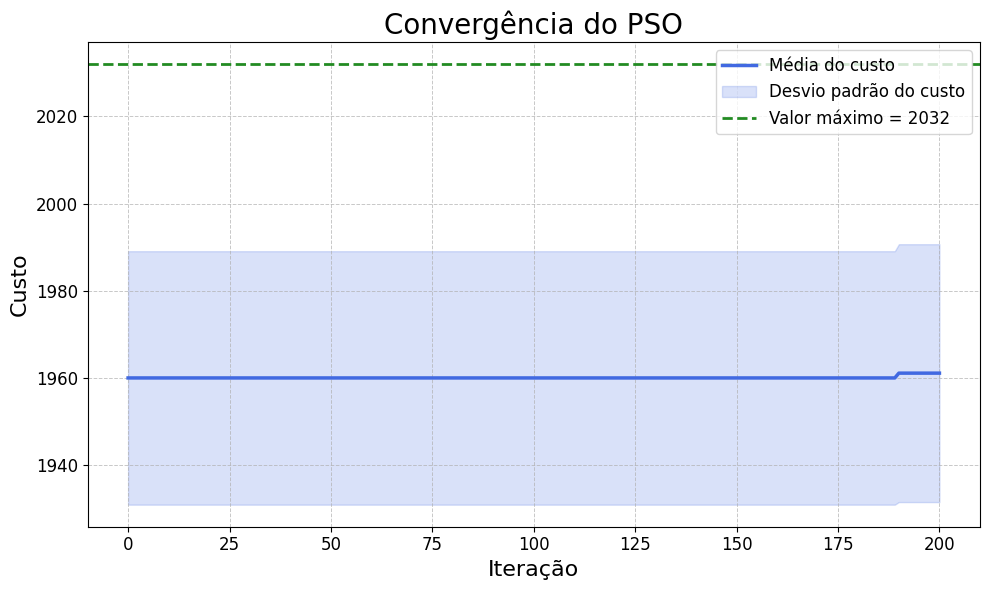

In [9]:
pso_stats.plot_convergence(
    title="Convergência do PSO",
    savefig="results/pso_convergence.png"
)

# Experimental do PSO

In [10]:
# --------- Execução ---------
num_items = knapsack.n_items
capacity = knapsack.capacity
weights = [item.weight for item in knapsack.items]
values = [item.value for item in knapsack.items]

In [11]:
# Exibe resultados
print("Melhor valor encontrado:", best_value)
print("Peso total:", np.sum(solution * weights))
print("Itens selecionados:", np.where(solution == 1)[0])

# Plota convergência
plt.plot(history)
plt.xlabel("Iterações")
plt.ylabel("Melhor valor")
plt.title("Convergência do PSO - Knapsack")
plt.grid()
plt.show()


Melhor valor encontrado: 2066


NameError: name 'solution' is not defined

In [ ]:
best_value_global = 0
best_solution_global = None

for _ in range(10):
    pso = pso_knapsack(weights, values, capacity)
    solution, value, _ = pso.run()
    if value > best_value_global:
        best_value_global = value
        best_solution_global = solution

print("Melhor valor encontrado:", best_value_global)
print("Peso total da solução:", sum(best_solution_global * weights))
print("Itens escolhidos:", [i for i, bit in enumerate(best_solution_global) if bit == 1])